In [8]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mitsubisi/nst_0620020808 1.csv
/kaggle/input/stock/Netflix.csv
/kaggle/input/stock/Microsoft.csv
/kaggle/input/stock/Google.csv
/kaggle/input/stock/Amazon.csv
/kaggle/input/stock/Apple.csv


In [9]:
# Reference: https://github.com/ctxj/Time-Series-Transformer-Pytorch/tree/main
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import math
import time
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [10]:
amzn_df = pd.read_csv("/kaggle/input/mitsubisi/nst_0620020808 1.csv")
appl_df = pd.read_csv("/kaggle/input/stock/Apple.csv")
googl_df = pd.read_csv("/kaggle/input/stock/Google.csv")
msft_df = pd.read_csv("/kaggle/input/stock/Microsoft.csv")
nflx_df = pd.read_csv("/kaggle/input/stock/Netflix.csv")

In [11]:
stock_df = dict()
stock_df['AMZN'] = amzn_df
stock_df['APPL'] = appl_df
stock_df['GOOGL'] = googl_df
stock_df['MSFT'] = msft_df
stock_df['NFLX'] = nflx_df

In [12]:
close_appl = stock_df['APPL'].Close

In [13]:
log_prices = np.diff(np.log(close_appl))

In [14]:
log_prices_csum = log_prices.cumsum() # Cumulative sum of log prices

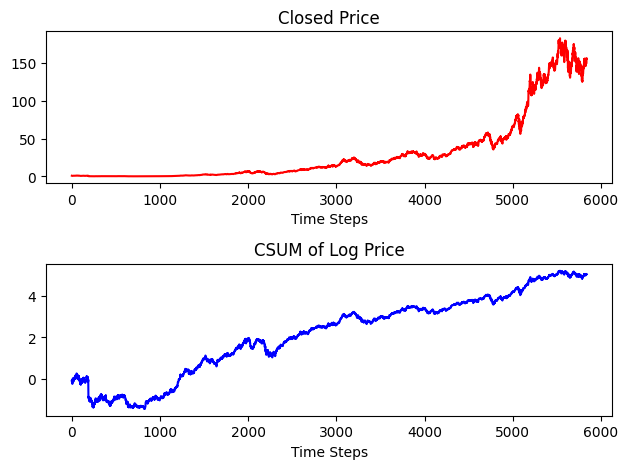

In [15]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(close_appl, color='red')
ax1[0].set_title('Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(log_prices_csum, color='blue')
ax1[1].set_title('CSUM of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()

In [16]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
input_window = 7 # number of input time steps
output_window = 1 # number of prediction steps (equals to one)
batch_size = 100

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:x.size(0), :])

In [18]:
class Transformer(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, dropout=0.1):
        # feautre_size equals to embedding dimension (d_model)
        super().__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        
        # Apply nhead multi-head attention
        # d_key, d_query, d_value = d_model // n_head
        self.encoder_layer = TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        
        # Use num_layers encoders
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # For simple time-series prediction, decoder just uses FC layer
        self.decoder = nn.Linear(feature_size, 1)
        self._init_weights()

    def _init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1) # Lower Triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

In [19]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [20]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [21]:
train_data, test_data = get_data(log_prices, 0.7) # 70% for train and 30% for test

/tmp/ipykernel_34/1471902572.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(inout_seq)


In [22]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [23]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss = total_loss + loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [24]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [25]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [26]:
model = Transformer().to(device)

criterion = nn.MSELoss() 
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

N_EPOCHS = 150

In [27]:
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_data)

    if (epoch % N_EPOCHS == 0):  # Valid model after last training epoch
        val_loss = evaluate(model, test_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                   (time.time() - epoch_start_time),
                                                                                   val_loss))
        print('-' * 80)

    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     8/   40 batches | lr 0.0000500000 | 143.23 ms | loss 0.4173810
| epoch   1 |    16/   40 batches | lr 0.0000500000 | 104.56 ms | loss 0.7675445
| epoch   1 |    24/   40 batches | lr 0.0000500000 | 101.96 ms | loss 0.9525565
| epoch   1 |    32/   40 batches | lr 0.0000500000 | 100.81 ms | loss 0.7756019
| epoch   1 |    40/   40 batches | lr 0.0000500000 | 105.15 ms | loss 0.1811037
--------------------------------------------------------------------------------
| end of epoch   1 | time:  4.45s
--------------------------------------------------------------------------------
| epoch   2 |     8/   40 batches | lr 0.0000451250 | 121.39 ms | loss 9.3480218
| epoch   2 |    16/   40 batches | lr 0.0000451250 | 107.89 ms | loss 20.5839283
| epoch   2 |    24/   40 batches | lr 0.0000451250 | 104.75 ms | loss 11.7712897
| epoch   2 |    32/   40 batches | lr 0.0000451250 | 103.37 ms | loss 2.0475252
| epoch   2 |    40/   40 batches | lr 0.0000451250 | 100.00 ms | loss 3.

In [28]:
predicted_seq, real_seq = predict(model, test_data)

4.054546356201172 sec


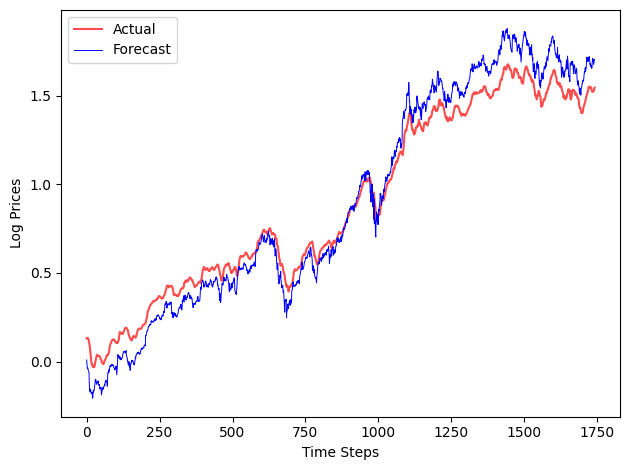

In [29]:
fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq, color='red', alpha=0.7)
ax2.plot(real_seq, color='blue', linewidth=0.7)
ax2.legend(['Actual', 'Forecast'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()

In [30]:
close_msft = stock_df['MSFT'].Close
log_prices2 = np.diff(np.log(close_msft))

In [31]:
train_data2, test_data2 = get_data(log_prices2, 0.7)

In [32]:
predicted_seq2, real_seq2 = predict(model, test_data2)

3.8697612285614014 sec


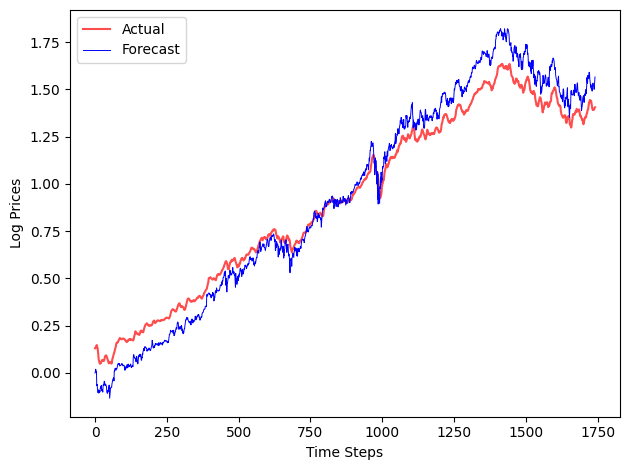

In [33]:
fig3, ax3 = plt.subplots(1, 1)

ax3.plot(predicted_seq2, color='red', alpha=0.7)
ax3.plot(real_seq2, color='blue', linewidth=0.7)
ax3.legend(['Actual', 'Forecast'])
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Log Prices')

fig3.tight_layout()